<a href="https://colab.research.google.com/github/GilRtt/UAS_PCD/blob/main/klasifikasi_kualitas_buah_dan_sayuran_menggunakan_CNN_(Jeruk).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing Data

In [ ]:
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data Dari File

In [ ]:
def loadData(dataset_p, nama_file, tag_dataset, path_data):
  for path, subdirs, files in os.walk(dataset_p):
      for name in files:
          path_data.append(os.path.join(path, name))
          tag_dataset.append(path.split('/')[-1])
          nama_file.append(name)
  return(nama_file, tag_dataset, path_data)

In [ ]:
data_path= '/content/drive/MyDrive/PCD/orange/data'
dataset_path= '/content/drive/MyDrive/PCD/orange/dataset'

In [ ]:
namaFile = []
tagData = []
pathData = []

loadData(data_path, namaFile, tagData, pathData)

df = pd.DataFrame({"Path":pathData,'Nama File':namaFile,"Tag":tagData})
df.groupby(['Tag']).size()

Tag
fresh_orange    1466
stale_orange    1595
dtype: int64

In [ ]:
#cek sample data teratas dr dataframe
df.head()

,Path,Nama File,Tag
0,/content/drive/MyDrive/PCD/orange/data/stale_o...,rotated_by_30_Screen Shot 2018-06-12 at 11.42....,stale_orange
1,/content/drive/MyDrive/PCD/orange/data/stale_o...,rotated_by_45_Screen Shot 2018-06-12 at 11.27....,stale_orange
2,/content/drive/MyDrive/PCD/orange/data/stale_o...,rotated_by_45_Screen Shot 2018-06-12 at 11.25....,stale_orange
3,/content/drive/MyDrive/PCD/orange/data/stale_o...,rotated_by_45_Screen Shot 2018-06-12 at 11.26....,stale_orange
4,/content/drive/MyDrive/PCD/orange/data/stale_o...,rotated_by_45_Screen Shot 2018-06-12 at 11.27....,stale_orange


## Split Data

In [ ]:
#load library untuk train test split
from sklearn.model_selection import train_test_split

#variabel yang digunakan pada pemisahan data ini
X= df['Path']
y= df['Tag']

In [ ]:
# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=300)

In [ ]:
# kemudian data test dibagi menjadi 2 sehingga menjadi data test dan data validation.
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=100)

In [ ]:
# inisialisasi variabel dataframe untuk menyimpan data yang sudah di pisahkan.

df_tr = pd.DataFrame({'Path':X_train
              ,'Tag':y_train
             ,'Set':'train'})

df_te = pd.DataFrame({'Path':X_test
              ,'Tag':y_test
             ,'Set':'test'})

df_val = pd.DataFrame({'Path':X_val
              ,'Tag':y_val
             ,'Set':'validation'})

In [ ]:
# melihat jumlah data pada masing masing folder set(train, test, validation) menggunakan fungsi append
df_semua_data = df_tr.append([df_te, df_val]).reset_index(drop=1)\

print('Ukuran Data Train', len(df_tr))
print('Ukuran Data Validation', len(df_te))
print('Ukuran Data Test', len(df_val))

print('===================================================== \n')
print(df_semua_data.groupby(['Set','Tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_semua_data.sample(3)

Ukuran Data Train 2448
Ukuran Data Validation 306
Ukuran Data Test 307

Set         Tag         
test        fresh_orange     154
            stale_orange     152
train       fresh_orange    1169
            stale_orange    1279
validation  fresh_orange     143
            stale_orange     164
dtype: int64 




<ipython-input-11-c042921349d5>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_semua_data = df_tr.append([df_te, df_val]).reset_index(drop=1)\


,Path,Tag,Set
349,/content/drive/MyDrive/PCD/orange/data/stale_o...,stale_orange,train
2511,/content/drive/MyDrive/PCD/orange/data/stale_o...,stale_orange,test
1364,/content/drive/MyDrive/PCD/orange/data/fresh_o...,fresh_orange,train


## Simpan Data

In [ ]:
import shutil
from tqdm.notebook import tqdm as tq

In [ ]:
for index, row in tq(df_semua_data.iterrows()):
  file_path = row['Path']

  # cek folder
  if os.path.exists(file_path) == False:
    file_path = os.path.join(dataset_path,row['Tag'],row['Image'].split('.')[0])

  #membuat folder tiap dataset
  if os.path.exists(os.path.join(dataset_path,row['Set'],row['Tag'])) == False:
    os.makedirs(os.path.join(dataset_path,row['Set'],row['Tag']))

  #mendefinisikan file tujuan ke folder(train, test dan validation)
  nama_file_tujuan = file_path.split('/')[-1]
  file_tujuan = os.path.join(dataset_path,row['Set'],row['Tag'], nama_file_tujuan)

  #copy file dari source ke dest
  if os.path.exists(file_tujuan) == False:
    shutil.copy2(file_path,file_tujuan)

0it [00:00, ?it/s]

# Dataset Generator

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

In [ ]:
def input(ukuran_gmb):
  channel = (3, )
  input_shape = ukuran_gmb + channel
  return(input_shape)
# ukuran_gambar => ukuran matriks piksel gambar ex: "(125,125)"

In [ ]:
def imageGenerator(jml_rotasi, lebar, tinggi, shear, zoom, horizontalFlip):
  imageGen = ImageDataGenerator(rotation_range=jml_rotasi,
                                width_shift_range=lebar,
                                height_shift_range=tinggi,
                                shear_range=shear,
                                zoom_range=zoom,
                                horizontal_flip= horizontalFlip)
  return(imageGen)

# n_rescale => nilai rescale gambar ex:"1. / 255"
# shear => nilai shear untuk gambar
# zoom => nilai besaran zoom untuk gambar
# horizontalFlip => berisi boolean untuk aktif atau tidaknya

In [ ]:
jml_rotasi = 40
lebar = 0.2
tinggi = 0.2
shear = 0.2
zoom = 0.2
horizontalFlip = True

datagen = imageGenerator(jml_rotasi, lebar, tinggi, shear, zoom, horizontalFlip)

In [ ]:
img = load_img('/content/drive/MyDrive/PCD/orange/dataset/train/fresh_orange/Screen Shot 2018-06-12 at 11.50.28 PM.png')
save_path = '/content/drive/MyDrive/PCD/orange/coba/hasil generator'

In [ ]:
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0

for batch in datagen.flow(x,save_to_dir=save_path, save_prefix='hasil generator', save_format='jpg'):
  i += 1
  if i > 10:
    break

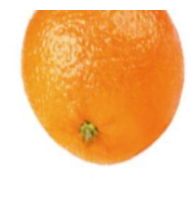

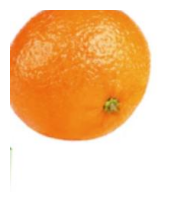

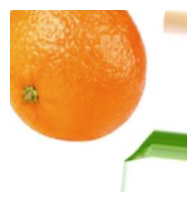

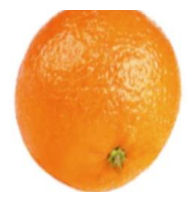

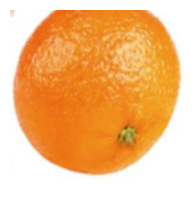

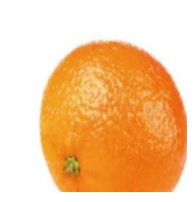

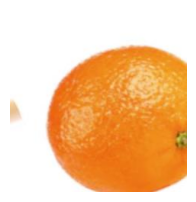

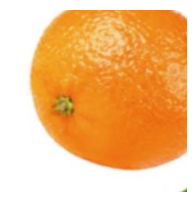

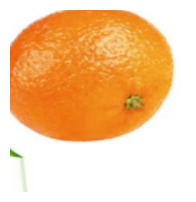

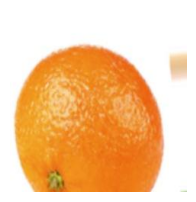

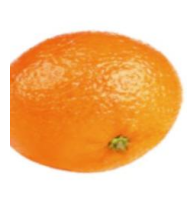

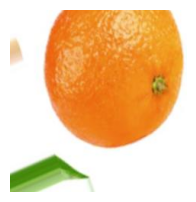

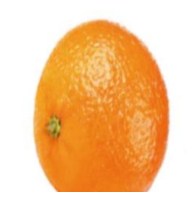

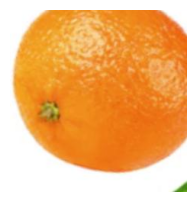

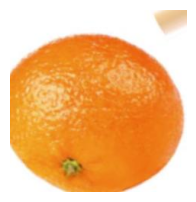

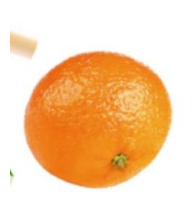

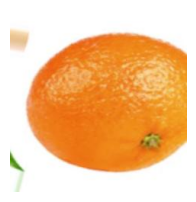

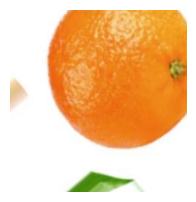

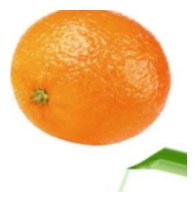

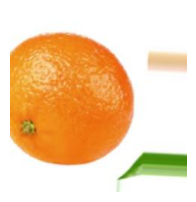

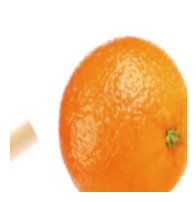

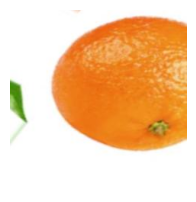

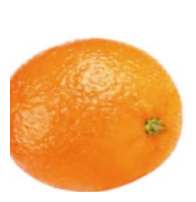

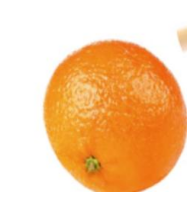

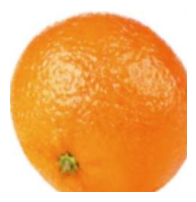

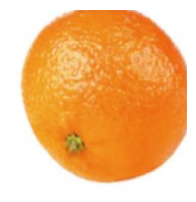

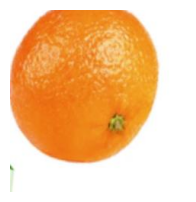

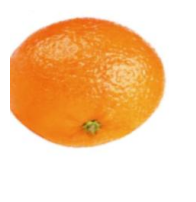

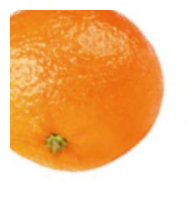

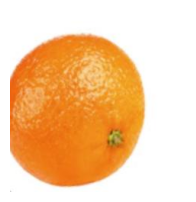

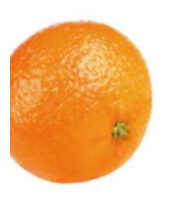

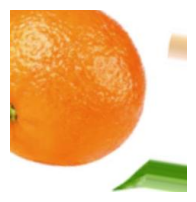

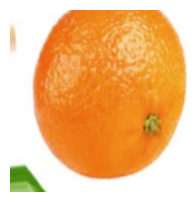

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

file_name_generator = []
tag_generator = []
full_path_generator = []

loadData(save_path, file_name_generator, tag_generator, full_path_generator)
df_generator = pd.DataFrame({"Path":full_path_generator,'Nama File':file_name_generator})

for gmb_hsl_generator in range (0, len(full_path_generator)):
  gambar_uji = Image.open(full_path_generator[gmb_hsl_generator])
  fig = plt.figure(figsize=(5,15))
  ax  = fig.add_subplot(1,2,1)
  ax.axis("off")
  ax.imshow(gambar_uji)
  plt.show()

In [ ]:
# train, testing, validation
def datasetGenerator(datagen, data, gambar_size, batch_s, mode, shufle):
  generator = datagen.flow_from_directory(data,
                                          target_size= gambar_size,
                                          batch_size=batch_s,
                                          class_mode=mode,
                                          shuffle=shufle)
  return(generator)

# datagen => function "imageGenerator"
# data => patch dataset (trainData, testData dan validData)
# gambar_size => ukuran matriks piksel gambar ex: "(125,125)"
# batch_s => nilai besarnya batch yang dipakai
# mode => 2 option 'categorial' dan 'binary'
# shufle => berisi boolean untuk aktif atau tidaknya

In [ ]:
# Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [ ]:
trainData = '/content/drive/MyDrive/PCD/orange/dataset/train'
validData = '/content/drive/MyDrive/PCD/orange/dataset/validation'
testData = '/content/drive/MyDrive/PCD/orange/dataset/test'

In [ ]:
gambar_size1 = (256, 256)
gambar_size2 = (128, 128)
gambar_size3 = (64, 64)

batch_size = 16
shufle = True

# mode binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# mode categorical = 1,2,3,4,5
mode = 'categorical'


## Dataset Generator Ukuran Gambar (256, 256)

In [ ]:
train_generator_256 = datasetGenerator(datagen, trainData, gambar_size1, batch_size, mode, shufle)
val_generator_256 = datasetGenerator(datagen, validData, gambar_size1, batch_size, mode, shufle)
test_generator_256 = datasetGenerator(datagen, testData, gambar_size1, batch_size, mode, shufle)

Found 2448 images belonging to 2 classes.
Found 307 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [ ]:
labels_256 = train_generator_256.class_indices.keys()
print(labels_256)

num_class_256 = test_generator_256.num_classes

dict_keys(['fresh_orange', 'stale_orange'])


In [ ]:
input_shape_256 = input(gambar_size1)

In [ ]:
train_data_256 = tf_data_generator(train_generator_256, input_shape_256)
test_data_256 = tf_data_generator(test_generator_256, input_shape_256)
val_data_256 = tf_data_generator(val_generator_256, input_shape_256)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


# Membuat Struktur CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
import time

In [ ]:
def strukturCNN(input_shape, num_class):
  model = Sequential()
  #Langkah 1 convolution
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  #Langkah 2 Pooling
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_class))
  model.add(Activation('softmax'))

  # Menjalankan model
  print('============ Compiling Model', input_shape, '============')
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return(model)

In [ ]:
 # lihat model yang telah dibangun
def model_diagram(model, path_model, nm_model):
  model_d = tf.keras.utils.plot_model(model,
                            to_file = os.path.join(path_model, nm_model),
                            show_shapes=True,
                            show_layer_names=True,
                            rankdir='TB',
                            expand_nested=True,
                            dpi=55)
  return(model_d)


In [ ]:
path_model = "/content/drive/MyDrive/PCD/orange/model"

============ Compiling Model (256, 256, 3) ============


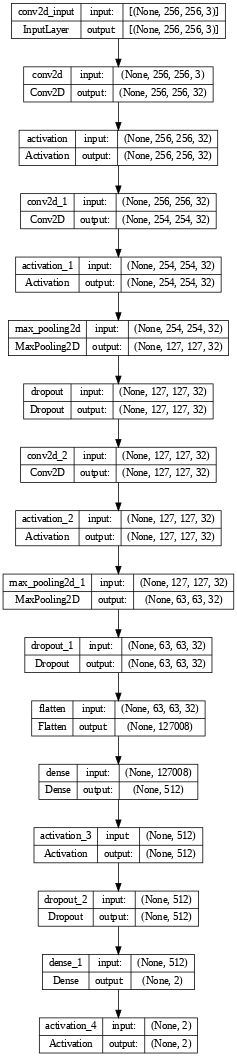

In [ ]:
model_256 = strukturCNN(input_shape_256, num_class_256)
model_diagram(model_256, path_model, 'model_256.png')

# Train Model CNN

## Persiapan Model CNN

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# training model cnn
def modelTrain(model, train_data, train_generator, n_epoch, val_data, val_generator, shufle, n_verbose):
    history = model.fit(x=train_data,
          steps_per_epoch=len(train_generator),
          epochs=n_epoch,
          validation_data=val_data,
          validation_steps=len(val_generator),
          shuffle=shufle,
          verbose = n_verbose)
    return(history)

In [ ]:
def simpan_model(path_model, nama_file_model, model):
  simpan_model_path = os.path.join(path_model, nama_file_model)

  if os.path.exists(os.path.join(path_model)) == False:
      os.makedirs(os.path.join(path_model))

  print('Saving Model di {}...'.format(simpan_model_path))
  model.save(simpan_model_path,include_optimizer=False)

## Plot MSE dan MAE

In [ ]:
# Plot MAE
def mae(hasil_training, judul_plot_mae, path_mae, nm_mae):
  fig = plt.figure()
  plt.plot(hasil_training.history['loss'], label='Training Loss')
  plt.plot(hasil_training.history['val_loss'], label='Validation Loss')
  plt.title(judul_plot_mae)
  plt.ylabel('value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()
  fig.savefig(os.path.join(path_mae, nm_mae))

# nm_plot = diisi string untuk judul plot

In [ ]:
def mse(hasil_training, judul_plot_mse, path_mse, nm_mse):
  fig = plt.figure()
  plt.plot(hasil_training.history['accuracy'], label='Training Accuracy')
  plt.plot(hasil_training.history['val_accuracy'], label='Validation Accuracy')
  plt.title(judul_plot_mse)
  plt.ylabel('value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()
  fig.savefig(os.path.join(path_mse, nm_mse))

  # nm_plot = diisi string untuk judul plot

In [ ]:
epoch3 = 20

## Training Epoch 20

### ukuran gambar 256

In [ ]:
start = time.time()
training_epoch100_256 = modelTrain(model_256,
                                  train_data_256,
                                  train_generator_256,
                                  epoch3,
                                  val_data_256,
                                  val_generator_256,
                                  shufle,
                                  1)
end = time.time()
print("Waktu yang dibutuhkan: {:5.4f} Menit".format((end-start)/60.0))

Epoch 1/20
153/153 [==============================] - 771s 5s/step - loss: 255.0870 - accuracy: 0.5188 - val_loss: 0.6973 - val_accuracy: 0.5733
Epoch 2/20
153/153 [==============================] - 74s 488ms/step - loss: 0.7323 - accuracy: 0.5866 - val_loss: 0.6947 - val_accuracy: 0.5244
Epoch 3/20
153/153 [==============================] - 69s 456ms/step - loss: 0.6863 - accuracy: 0.5764 - val_loss: 0.6874 - val_accuracy: 0.5570
Epoch 4/20
153/153 [==============================] - 80s 529ms/step - loss: 0.7023 - accuracy: 0.5253 - val_loss: 0.6909 - val_accuracy: 0.5309
Epoch 5/20
153/153 [==============================] - 70s 461ms/step - loss: 0.6999 - accuracy: 0.5159 - val_loss: 0.6903 - val_accuracy: 0.5375
Epoch 6/20
153/153 [==============================] - 69s 452ms/step - loss: 0.6959 - accuracy: 0.5212 - val_loss: 0.6904 - val_accuracy: 0.5375
Epoch 7/20
153/153 [==============================] - 76s 497ms/step - loss: 0.6939 - accuracy: 0.5135 - val_loss: 0.6884 - val_ac

In [ ]:
simpan_model(path_model, 'model20_256_.h5', model_256)

Saving Model di /content/drive/MyDrive/PCD/orange/model/model20_256_.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


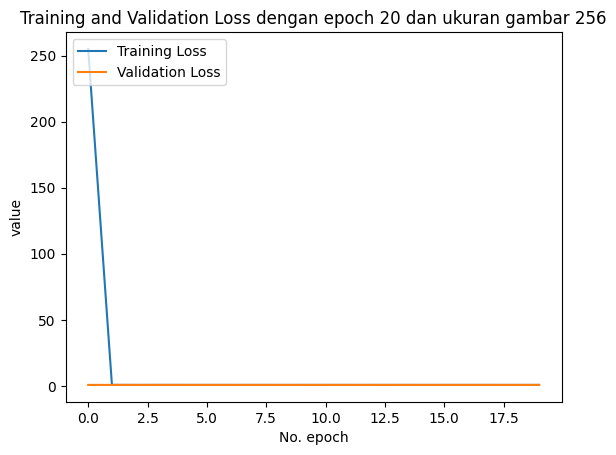

In [ ]:
# Plot hasil epoch100: MAE
plot_mae100_256 = 'Training and Validation Loss dengan epoch 20 dan ukuran gambar 256'
mae(training_epoch100_256, plot_mae100_256, path_model, 'MAE256_epoch20.png')

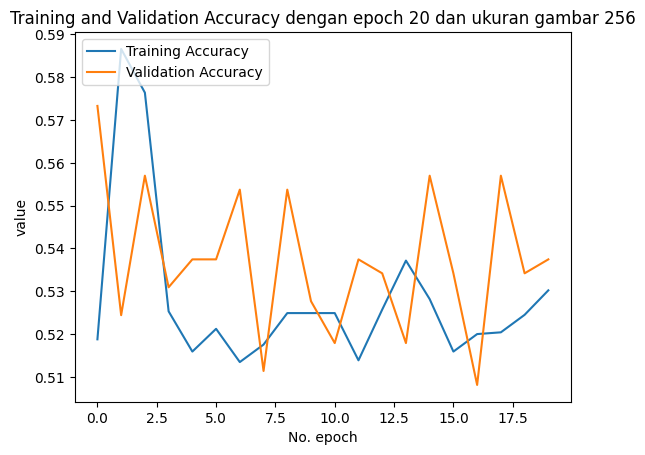

In [ ]:
# Plot hasil epoch100: MSE
plot_mse100_256 = 'Training and Validation Accuracy dengan epoch 20 dan ukuran gambar 256'
mse(training_epoch100_256, plot_mse100_256, path_model, 'MSE256_epoch100.png')

# Uji Model

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:
# path_uji = '/content/drive/MyDrive/Colab Notebooks/dataset/test'
path_uji = '/content/drive/MyDrive/PCD/orange/coba'

label = ['fresh_orange','stale_orange']

## Load Model

In [ ]:
def preprocess(img,ukuran_image):
    nimg = img.convert('RGB').resize(ukuran_image, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [ ]:
def modelTesting(model_path):
  model_test = load_model(model_path,compile=False)
  return(model_test)

## Uji Model Fiting Menggunakan Cofusion Matriks

In [ ]:
def uji(path_file_uji,gambar_size,model_uji,prediksi,tag_file_uji, hasil_prediksi,pred_bnr,nilai):
  for gmb_test in range (0, len(path_file_uji)):
    gambar_uji = Image.open(path_file_uji[gmb_test])
    h = preprocess(gambar_uji,gambar_size)
    X = reshape([h])
    y = model_uji.predict(X)
    # print( label[np.argmax(y)], np.max(y) )
    prediksi.append(label[np.argmax(y)])
    if(label[np.argmax(y)] == tag_file_uji[gmb_test]):
      hasil_prediksi.append('BENAR')
      pred_bnr+=1
      nilai.append(np.max(y))
    else:
      hasil_prediksi.append('SALAH')
      nilai.append(np.max(y))

  # menghitung akurasi menggunakan confusion matrix
  cm_akurasi = pred_bnr/len(tag_file_uji)*100
  print(int(cm_akurasi),'%')

### Uji Model Epoch 50


#### ukuran gambar 256

In [ ]:
model_100_256 = '/content/drive/MyDrive/PCD/orange/model/model20_256_.h5'
nama_file100_256 = []
tag_file_uji100_256 = []
path_file_uji100_256 = []
prediksi100_256 = []
hasil_prediksi100_256 = []
nilai100_256 = []
pred_bnr100_256 = 0

loadData(path_uji,
         nama_file100_256,
         tag_file_uji100_256,
         path_file_uji100_256)

model_uji = modelTesting(model_100_256)

uji(path_file_uji100_256,
    gambar_size1,
    model_uji,
    prediksi100_256,
    tag_file_uji100_256,
    hasil_prediksi100_256,
    pred_bnr100_256,
    nilai100_256)

hasil_pred = pd.DataFrame({'Prediksi Sistem':prediksi100_256,
                           "Data Asal":tag_file_uji100_256,
                           "Hasil Prediksi":hasil_prediksi100_256,
                           "prediksi":nilai100_256,
                           'File':nama_file100_256})

hasil_pred.head(len(path_file_uji100_256))

1/1 [==============================] - 0s 19ms/step
0 %


,Prediksi Sistem,Data Asal,Hasil Prediksi,prediksi,File
0,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_1657.jpg
1,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_1713.jpg
2,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_4791.jpg
3,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_177.jpg
4,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_9957.jpg
5,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_609.jpg
6,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_4875.jpg
7,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_8560.jpg
8,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_1628.jpg
9,stale_orange,hasil generator,SALAH,0.524855,hasil generator_0_9400.jpg
